# Introducción

Sweet Lift Taxi ha recopilado un extenso historial de pedidos de taxis realizados en aeropuertos, con el objetivo de optimizar la disponibilidad de conductores durante las horas pico. 

Este proyecto se centra en desarrollar un modelo de predicción capaz de estimar, con una hora de anticipación, la cantidad de solicitudes de taxi esperadas. La meta principal es construir una solución cuya precisión se evalúe mediante la métrica raíz del error cuadrático medio (RECM), asegurando que no supere el umbral de 48 en el conjunto de prueba. Esta predicción permitirá a la compañía tomar decisiones informadas para atraer más conductores en los momentos de mayor demanda y mejorar la eficiencia operativa.

# Preparación

Antes de adentrarse en el análisis y modelado de datos, se importaron una serie de librerías especializadas que facilitarán cada etapa del trabajo. Estas herramientas permiten desde la manipulación eficiente de grandes volúmenes de información y la generación de visualizaciones claras, hasta la aplicación de métodos estadísticos y modelos de predicción sofisticados. En la siguiente sección, se procederá a preparar y explorar los datos, utilizando estas librerías para extraer información relevante.

In [1]:
# Instalación de librería sktime
#!pip install sktime

In [2]:
# Importación de librerías

# Manipulación y Análisis de Datos
import pandas as pd
import numpy as np

# Visualización
import matplotlib.pyplot as plt
from sktime.utils.plotting import plot_series

# Análisis de Series Temporales
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Modelos de Machine Learning
from sklearn.linear_model    import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor

# Validación y Evaluación de Modelos
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

/home/alexkhype/jupyter/lib/python3.8/site-packages/xgboost/core.py:265: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc 2.28+) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(


In [3]:
# Carga de conjunto de datos
try:
    df = pd.read_csv('taxi.csv', index_col=[0], parse_dates=[0])
except:
    df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

# Ordenamiento del df por índice temporal
df.sort_index(inplace=True)

In [4]:
# Información general del DataFrame
df.info()

# Primeras filas del DataFrame
display(df.head(3))
display(df.tail(3))

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28


,num_orders
datetime,
2018-08-31 23:30:00,27
2018-08-31 23:40:00,39
2018-08-31 23:50:00,53


In [5]:
# Comprobación de orden ascendente
print('El conjunto de datos está ordenado ascendentemente:', df.index.is_monotonic_increasing)

El conjunto de datos está ordenado ascendentemente: True


El conjunto de datos analizado corresponde a una serie temporal univariada, compuesta por una única columna denominada 'num_orders'. En ella se registra el número de órdenes de taxi realizadas diariamente cada 10 minutos desde el primero de marzo hasta el 31 de agosto de 2018. De este modo, se dispone de una secuencia cronológica que permite analizar la evolución y los patrones de la demanda de taxis durante ese periodo específico.

# Análisis de datos

En esta sección se realizará un análisis y visualización de los datos con el objetivo de identificar la presencia de tendencia y estacionalidad en las series temporales. Este proceso permite descomponer la información en sus componentes fundamentales, facilitando la detección de patrones recurrentes a lo largo del tiempo, así como de cambios estructurales o ciclos. 

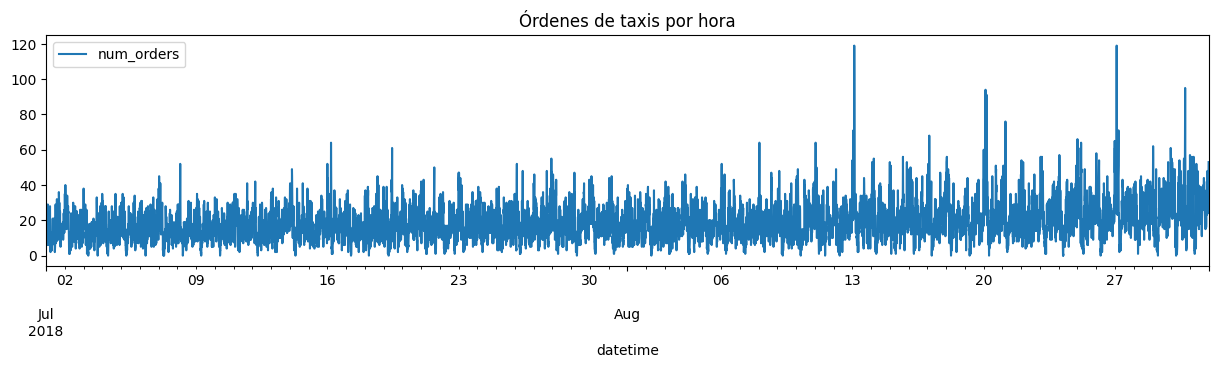

In [6]:
# Visualización de órdenes de taxis entre julio y agosto 2018
df['2018-07-01':'2018-08-31'].plot(figsize=(15,3))
plt.title('Órdenes de taxis por hora')
plt.show()

El gráfico muestra la evolución del número de órdenes de taxis por hora en los aeropuertos, abarcando el segmento de julio y agosto de 2018. Los datos están correctamente ordenados de manera ascendente según la fecha y hora, lo que permite observar claramente los patrones temporales

En primer lugar se procederá a hacer un re-muestreo de los datos para agruparlos por hora Al consolidar la información en intervalos horarios, se reduce el ruido presente en los datos de alta frecuencia, lo que contribuye a una visión más clara de las tendencias, estacionalidades y posibles anomalías.

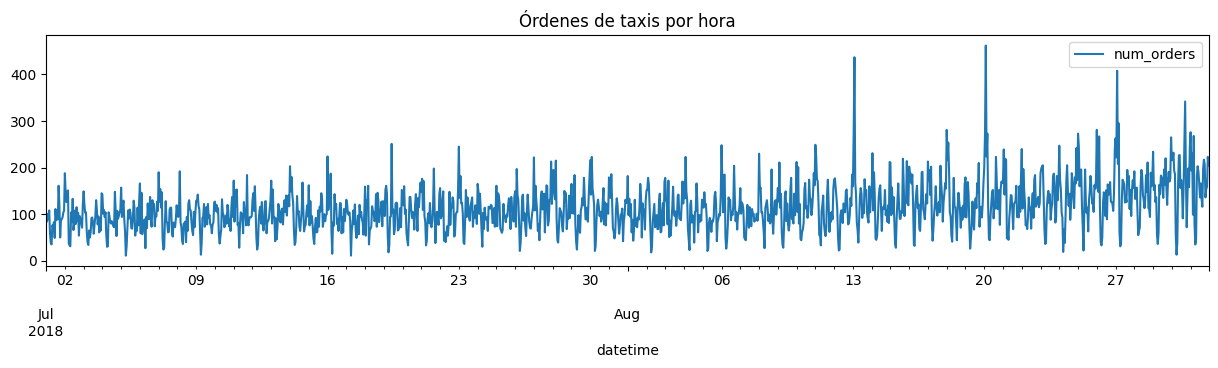

In [7]:
# Re-muestreo por hora sumando valores
df = df.resample('1H').sum()

# Visualización de órdenes de taxis entre julio y agosto 2018
df['2018-07-01':'2018-08-31'].plot(figsize=(15,3))
plt.title('Órdenes de taxis por hora')
plt.show()

## Visualización de periodos de tiempo

Se procede a visualizar los datos originales del periodo julio-agosto, seleccionado para facilitar la interpretación, con el fin de identificar sus componentes clave: tendencia, estacionalidad y residuos:

- **Tendencia:** Se refiere a la dirección general que siguen los datos a lo largo del tiempo, ya sea de forma ascendente, descendente o estable.

- **Estacionalidad:** Identifica las variaciones periódicas y predecibles que se repiten en intervalos regulares, como semanas, meses o estaciones del año.

- **Residuos:** Son las fluctuaciones o irregularidades que quedan tras eliminar la tendencia y la estacionalidad de la serie. Representan el componente aleatorio o impredecible, vinculado a factores puntuales o excepcionales.

In [8]:
# Función para visualización de periodos
def period(data, days):
    start = data.index.max() - pd.Timedelta(days=days)
    end = data.index.max()

    decomposed = seasonal_decompose(df[start:end])

    plt.figure(figsize=(12, 12))

    # Datos originales
    plt.subplot(411)
    data[start:end].plot(ax=plt.gca())
    plt.title(f'Órdenes de taxis de los últimos {days} días')

    # Tendencia
    plt.subplot(412)
    decomposed.trend.plot(ax=plt.gca())
    plt.title('Tendencia')

    # Estacionalidad
    plt.subplot(413)
    decomposed.seasonal.plot(ax=plt.gca())
    plt.title('Estacionalidad')

    # Residuos
    plt.subplot(414)
    decomposed.resid.plot(ax=plt.gca())
    plt.title('Residuos')

    plt.tight_layout()
    plt.show()

### Pedidos de taxi en los últimos 2 meses

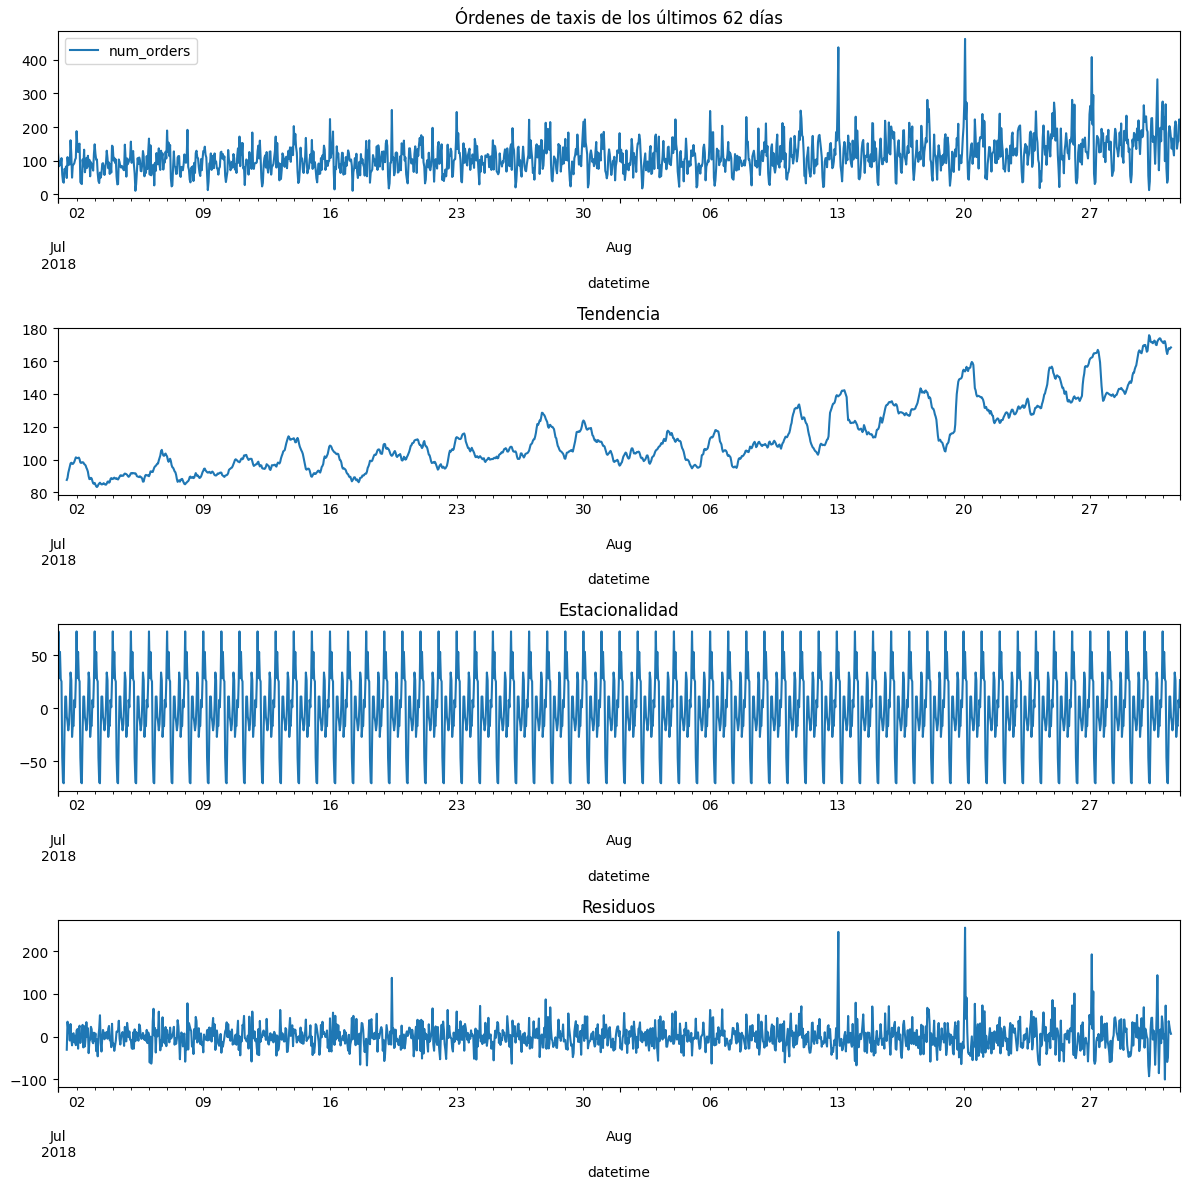

In [9]:
# Periodo de 62 días (2 meses)
period(df, 62)

**Tendencia general:** En los últimos dos meses, se observa una ligera tendencia creciente en el número de pedidos de taxis por hora. Esto sugiere un aumento progresivo en la demanda, posiblemente influenciado por factores estacionales (verano, vacaciones, etc.) o por cambios en la oferta/demanda en los aeropuertos.

**Estacionalidad:** Existe una estacionalidad diaria muy marcada: cada día se observan picos de demanda en las primeras horas de la mañana y en la noche.

**Residuos:** Se muestran picos de variabilidad aproximadamente cada 7 días, lo que podría estar relacionado con los fines de semana o días específicos de alta demanda.

### Pedidos de taxi en los últimos 14 días

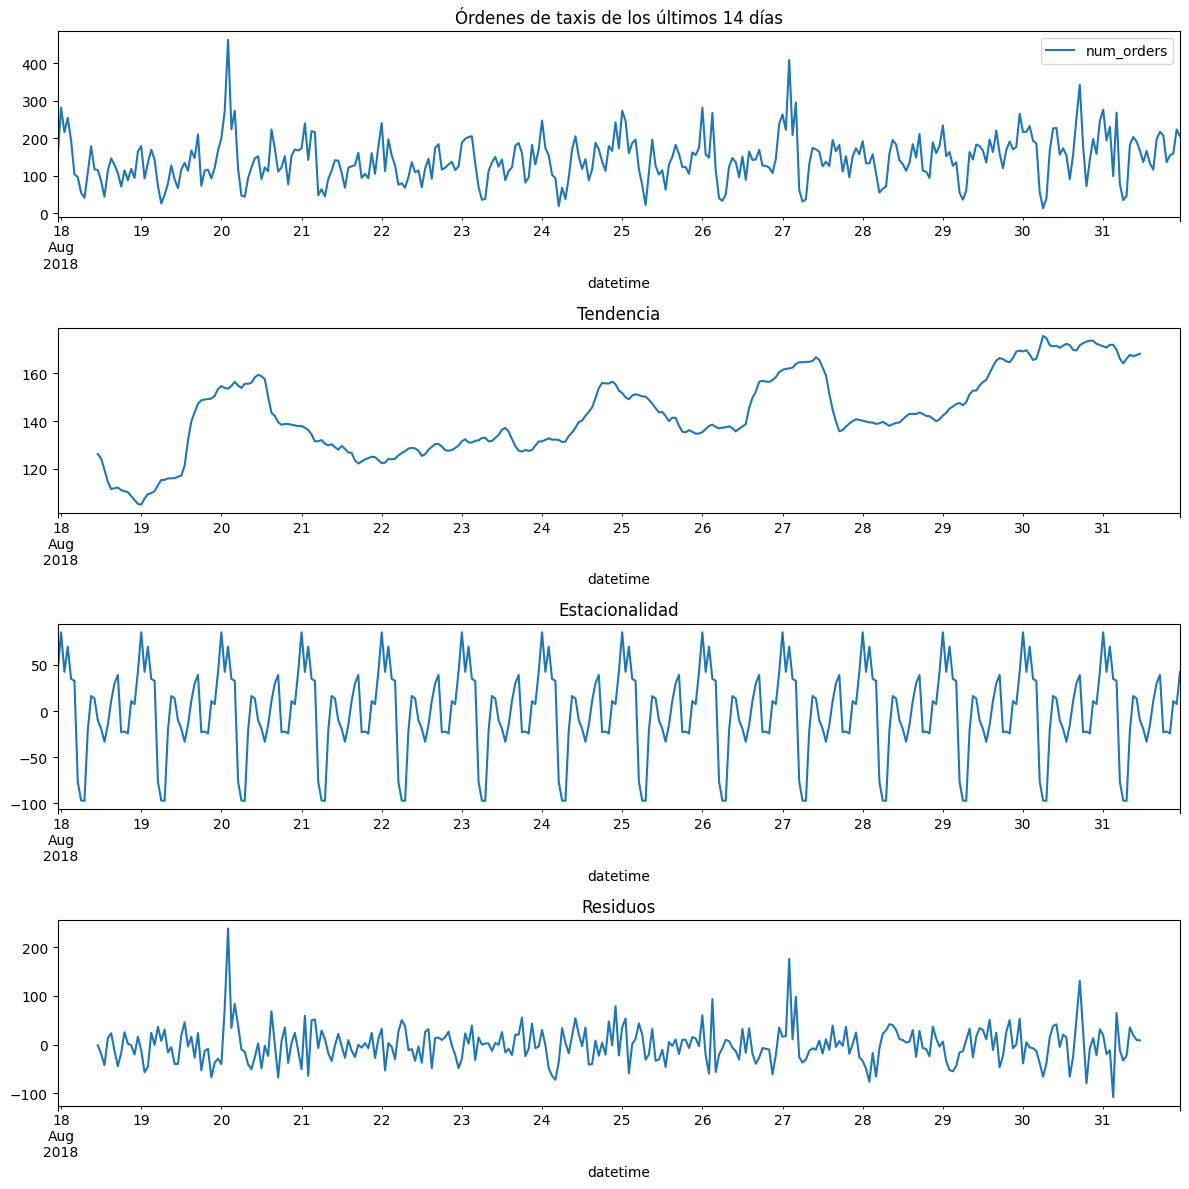

In [10]:
# Periodo de 7 días (1 semana)
period(df, 14)

**Tendencia general:** En periodos más cortos (últimos 7-14 días), la tendencia muestra cierta inestabilidad, aunque el comportamiento general sigue siendo al alza.

**Estacionalidad:** Los patrones se repiten de manera consistente, lo que indica que la demanda está fuertemente influenciada por cambios de turno, horarios de vuelos y rutinas diarias de los usuarios.

**Residuos:** Cuando se observan en un periodo más corto, encontramos que los picos ocurren en los días lunes (13, 20, 27), lo que indica que el comienzo de semana ejerce una fuerte influencia en la demanda de taxis.

## Comprobación de estacionareidad

Para analizar una serie temporal de manera rigurosa, es fundamental establecer su estacionariedad. La razón principal es que muchos de los modelos suponen que las propiedades estadísticas de la serie —media, varianza y autocovarianza— permanecen constantes a lo largo del tiempo. Si la serie no es estacionaria, estas propiedades cambian, lo que puede llevar a inferencias erróneas y pronósticos poco fiables, ya que el comportamiento futuro de la serie podría diferir significativamente del pasado.

A continuación, se aplicará la prueba de raíz unitaria Dickey-Fuller aumentada (ADF) sobre la variable de interés. Esta prueba estadística evalúa la hipótesis nula de que la serie tiene una raíz unitaria, es decir, que es no estacionaria. Se interpretarán los resultados según el valor p: si es menor a 0.05, se concluye que la serie es estacionaria (se rechaza la hipótesis nula); si es mayor, no se puede rechazar la no estacionariedad.

In [11]:
# Prueba de raíz unitaria ADF
result = adfuller(df['num_orders'].dropna(), autolag='AIC')

# Resultados de la prueba
print('Estadística ADF:', result[0])
print('valor p:', result[1])

# Interpretación de la estacionariedad
if result[1] < 0.05:
    print("La serie es estacionaria (se rechaza H0).")
else:
    print("La serie no es estacionaria (no se rechaza H0).")

Estadística ADF: -3.068924289027955
valor p: 0.02894005140261296
La serie es estacionaria (se rechaza H0).


Con base en los resultados obtenidos, se concluye que la serie temporal es estacionaria, lo que permite avanzar con el análisis correspondiente.

## Determinación de retrasos

La función de autocorrelación (ACF) y la función de autocorrelación parcial (PACF) son herramientas que nos permiten entender cómo los valores pasados de una serie influyen en los valores futuros. La ACF mide la relación global entre una observación y sus valores anteriores en distintos retrasos, mientras que la PACF identifica la relación directa entre una observación y sus retrasos, excluyendo el efecto de los valores intermedios. 

Utilizaremos estas funciones para determinar qué retrasos (lags) deben incluirse como variables en los modelos predictivos, ya que los lags con valores altos de ACF o PACF suelen indicar una fuerte dependencia temporal. En este análisis, se eligieron los retrasos donde la ACF es mayor a 0.5 y la PACF mayor a 0.25 porque estos umbrales señalan correlaciones significativas, ayudando a seleccionar solo aquellos lags que aportan información relevante y directa para mejorar la precisión del modelo. (Se excluirá el lag 0, porque siempre es 1).

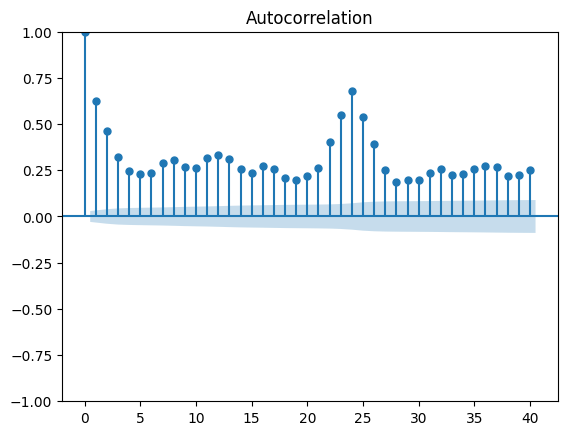

Retrasos con |ACF| > 0.5:
Retraso: 1, valor ACF: 0.6236
Retraso: 23, valor ACF: 0.5490
Retraso: 24, valor ACF: 0.6802
Retraso: 25, valor ACF: 0.5402



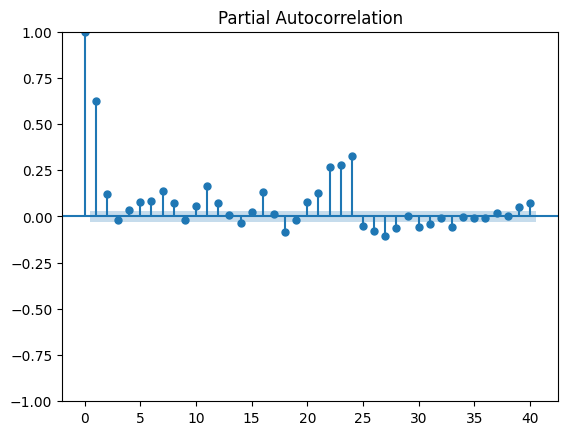

Retrasos con |PACF| > 0.25:
Retraso: 1, valor PACF: 0.6237
Retraso: 22, valor PACF: 0.2689
Retraso: 23, valor PACF: 0.2820
Retraso: 24, valor PACF: 0.3308


In [12]:
# Cálculo y filtrado de la ACF
acf_values = acf(df, nlags=40)
acf_above_05 = [(lag, val) for lag, val in enumerate(acf_values) if lag != 0 and abs(val) > 0.5]

# Cálculo y filtrado de la PACF
pacf_values = pacf(df, nlags=40)
pacf_above_02 = [(lag, val) for lag, val in enumerate(pacf_values) if lag != 0 and abs(val) > 0.2]

# Visualización de la ACF
plot_acf(df, lags=40)
plt.show()

# Presentación de retrasos con ACF significativa
print("Retrasos con |ACF| > 0.5:")
for lag, val in acf_above_05:
    print(f"Retraso: {lag}, valor ACF: {val:.4f}")
print()

# Visualización de la PACF
plot_pacf(df, lags=40)
plt.show()

# Presentación de retrasos con PACF significativa
print("Retrasos con |PACF| > 0.25:")
for lag, val in pacf_above_02:
    print(f"Retraso: {lag}, valor PACF: {val:.4f}")

La ACF identificó correlaciones fuertes en los retrasos 1, 23, 24 y 25, con valores superiores a 0.5, indicando una fuerte dependencia con observaciones previas tanto inmediatas como de aproximadamente un día antes (considerando datos horarios). Paralelamente, la PACF mostró correlaciones directas significativas en los retrasos 1, 22, 23 y 24, con valores superiores a 0.25, confirmando la influencia directa de estas observaciones pasadas. Con base en estos resultados, se seleccionarán los retrasos 1, 22, 23, 24 y 25 como características predictivas clave para nuestro modelo.

Adicionalmente, se implementará una ventana de media móvil de 24 observaciones, que corresponde perfectamente a un ciclo diario completo en datos horarios, capturando así la estacionalidad diaria presente en los datos y suavizando fluctuaciones aleatorias de corto plazo.

In [13]:
# Especificación de retraso y media móvil
lags_to_use = [1, 22, 23, 24, 25]
rolling_mean_window = 6

## Incorporación de características nuevas

A los retrasos y a la media móvil previamente definidos, se incorporarán variables de fecha y hora al conjunto de datos. Estas características temporales permiten capturar patrones estacionales y tendencias periódicas que pueden influir en la dinámica de la serie temporal. Al incluirlas, se facilita que los modelos posteriores identifiquen y aprovechen dichas regularidades, lo que contribuye a mejorar la precisión de las predicciones.

In [14]:
# Función para la creación de características
def make_features(df, lags_list, rolling_mean_size):
    df_features = df.copy()
    
    # Características de fecha y hora
    df_features['month'] = df.index.month
    df_features['day'] = df.index.day
    df_features['dayofweek'] = df.index.dayofweek
    df_features['hour'] = df.index.hour

    # Características de retraso
    for lag in lags_list:
        df_features[f'lag_{lag}'] = df['num_orders'].shift(lag)

    # Características de media móvil
    df_features['rolling_mean'] = df['num_orders'].shift(1).rolling(window=rolling_mean_size).mean()

    return df_features

In [15]:
# Creación de características nuevas en el df
df_features = make_features(df, lags_to_use, rolling_mean_window)

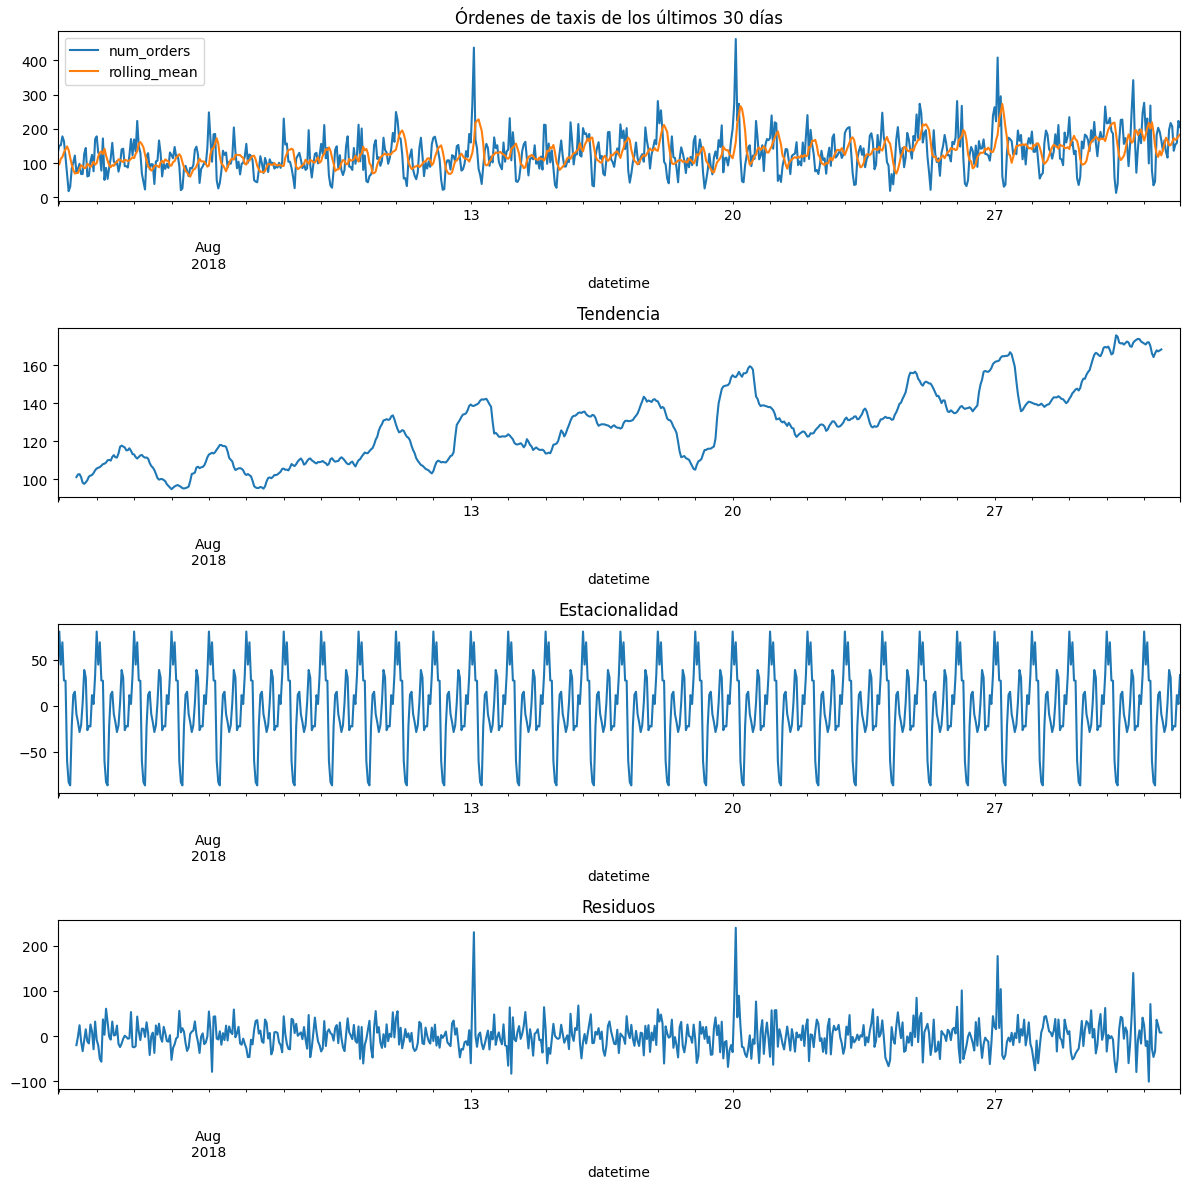

In [16]:
# Visualización de datos y media móvil
period(df_features[['num_orders','rolling_mean']], 30)

In [17]:
df_features.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   num_orders    4416 non-null   int64  
 1   month         4416 non-null   int32  
 2   day           4416 non-null   int32  
 3   dayofweek     4416 non-null   int32  
 4   hour          4416 non-null   int32  
 5   lag_1         4415 non-null   float64
 6   lag_22        4394 non-null   float64
 7   lag_23        4393 non-null   float64
 8   lag_24        4392 non-null   float64
 9   lag_25        4391 non-null   float64
 10  rolling_mean  4410 non-null   float64
dtypes: float64(6), int32(4), int64(1)
memory usage: 474.0 KB


La media móvil implementada (ventana de 6 horas) suaviza las fluctuaciones de corto plazo y permite visualizar con mayor claridad la tendencia subyacente. Se observa que la media móvil sigue de cerca la tendencia general, pero con menos ruido, confirmando la tendencia creciente y la presencia de ciclos diarios.

Tras la incorporación de nuevas características, el conjunto de datos final quedó conformado por 10 columnas: una correspondiente a los datos originales, cuatro relacionadas con información de fecha y hora, cinco asociadas a retrasos (lags) y una adicional con la media móvil. Como resultado del remuestreo a intervalos horarios, el número de observaciones se redujo de 26,496 registros originales a 4,416.

## Segmentación de conjuntos

Se procederá a segmentar el conjunto de datos en dos partes: un conjunto de entrenamiento y otro de prueba. Para ello, se reserva un 10 % de los datos para la prueba, mientras que el 90 % restante se utiliza para entrenar el modelo. La segmentación se realiza sin mezclar el orden original de las observaciones (`shuffle=False`), preservando así la secuencia temporal o el orden natural de los datos. Además, se fija una semilla (`random_state=12345`) para garantizar la reproducibilidad del proceso.

In [18]:
# Segmentación en conjuntos de entrenamiento y prueba
train, test = train_test_split(df_features, test_size=0.1, shuffle=False, random_state=12345)
train.dropna(inplace=True)

# Características y objetivo
X_train = train.drop('num_orders', axis=1)
X_test =  test.drop('num_orders', axis=1)

y_train = train['num_orders']
y_test  = test['num_orders']

# Verificación de tamaño tras segmentación
print(f'Conjunto de entrenamiento: {train.index.min()} --- {train.index.max()}  (n={len(train)})')
print(f'Conjunto de prueba : {test.index.min()} --- {test.index.max()}  (n={len(test)})')

Conjunto de entrenamiento: 2018-03-02 01:00:00 --- 2018-08-13 13:00:00  (n=3949)
Conjunto de prueba : 2018-08-13 14:00:00 --- 2018-08-31 23:00:00  (n=442)


Tras realizar la segmentación y eliminar las observaciones con valores ausentes generadas por la incorporación de retrasos, el conjunto de entrenamiento y el conjunto de prueba suman un total de 4,391 observaciones, lo que implica la pérdida de 25 registros respecto al total original.

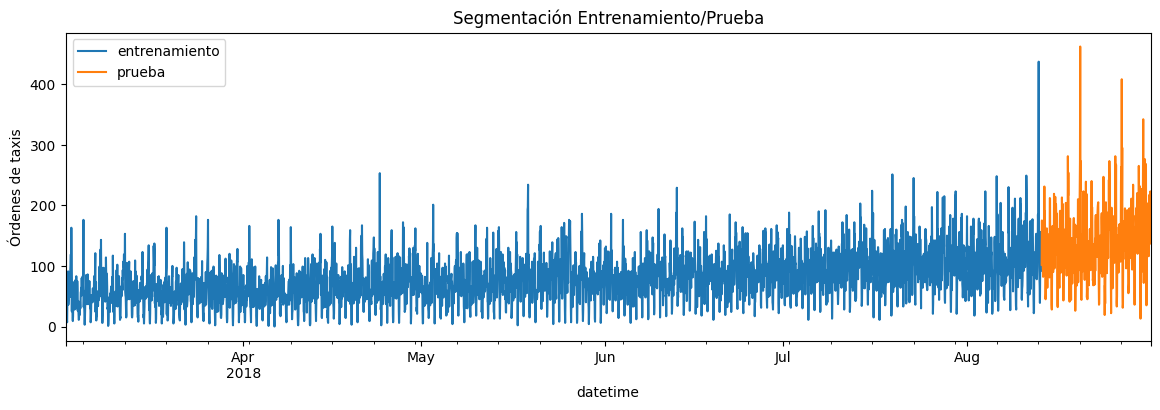

In [19]:
# Visualización del conjunto de entrenamiento y el de prueba
fig, ax = plt.subplots(figsize=(14, 4))
y_train.plot(ax=ax, label='entrenamiento')
y_test.plot(ax=ax, label='prueba')
plt.ylabel('Órdenes de taxis')
plt.title('Segmentación Entrenamiento/Prueba')
ax.legend()
plt.show()

Indicar cuántos obs se perdieron

# Evaluación de modelos

## Creación de funciones de evaluación y visualización

A continuación, se procederá a escribir una serie de funciones que resultarán útiles para la sección de evaluación de modelos. Estas rutinas permitirán automatizar la búsqueda de hiperparámetros, la comparación de resultados y la visualización del desempeño, facilitando así un análisis sistemático y reproducible de la calidad predictiva alcanzada.

In [20]:
# Función de búsqueda de mejores parámetros
def grid_search_cv(model, params):

    # División para validación cruzada en series temporales
    tscv = TimeSeriesSplit(n_splits=5)

    # Configuración de GridSearchCV
    grid_search= GridSearchCV(
        estimator=model, 
        param_grid=params, 
        scoring='neg_root_mean_squared_error', 
        cv=10)

    # Entrenamiento del modelo de búsqueda
    grid_search.fit(X_train, y_train)

    # Obtención del mejor puntaje de validación
    max_score = grid_search.cv_results_['mean_test_score'].max()

    # Identificación de los mejores hiperparámetros
    index_max_score = np.where(grid_search.cv_results_['mean_test_score'] == max_score)[0][0]
    best_params = grid_search.cv_results_['params'][index_max_score]

    # Impresión de los mejores hiperparámetros encontrados
    print(f'Mejores parámetros para {model.__class__.__name__}: {best_params}')

    # Guardado en variable externa
    return best_params

In [21]:
# Segmentación de días para la gráfica
start_train = train.index.max() - pd.Timedelta(days=1)
end_train = train.index.max()
start_test = test.index.min()
end_test = test.index.min() + pd.Timedelta(days=7)

# Función de visualización
def plot_model(model, pred):
    
    # Visualización de resultados
    plot_series(y_train[start_train:end_train], y_test[start_test:end_test], pred[start_test:end_test], 
                labels=["y entrenamiento", "y prueba", "y predicción"], x_label='Fecha', y_label='Órdenes de taxis', 
                title=f'Predicciones con {model.__class__.__name__}')

In [22]:
# Creación de tabla para comparación de modelos
summary_models = pd.DataFrame(columns=['model', 'rmse'])

# Presentación de tabla de comparación entre prueba de cordura y modelo analizado
def summary(df):
    return df.iloc[[0, -1]]

In [23]:
# Función de evaluación de modelo
def evaluate_model(model):
    
    # Entrenamiento del modelo
    model.fit(X_train, y_train) 

    # Predicciones del modelo
    pred = model.predict(X_test)
    pred = pd.Series(pred, index=y_test.index)

    # Cálculo RMSE
    rmse = round(mean_squared_error(y_test, pred, squared=False), 2)

    # Incorporación a tabla de resultados
    summary_models.loc[len(summary_models)] = {'model': model.__class__.__name__, 'rmse': rmse}

    # Visualización de predicciones
    plot_model(model, pred)

    # Presentación de parámetros utilizados
    print(f'{model.__class__.__name__} con parámetros:', model.get_params())

    # Guardado en variable externa
    return pred

## Modelo 0: Linear Regression (Prueba de cordura)

Se eligió la regresión lineal sin ajuste de hiperparámetros como referencia porque es un modelo sencillo, rápido de entrenar y fácil de interpretar. Esto permite establecer una base clara para comparar el desempeño de modelos más complejos: si un modelo avanzado no logra superar a la regresión lineal, probablemente su mayor complejidad no está justificada. 

LinearRegression con parámetros: {'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'positive': False}


,model,rmse
0,LinearRegression,46.02


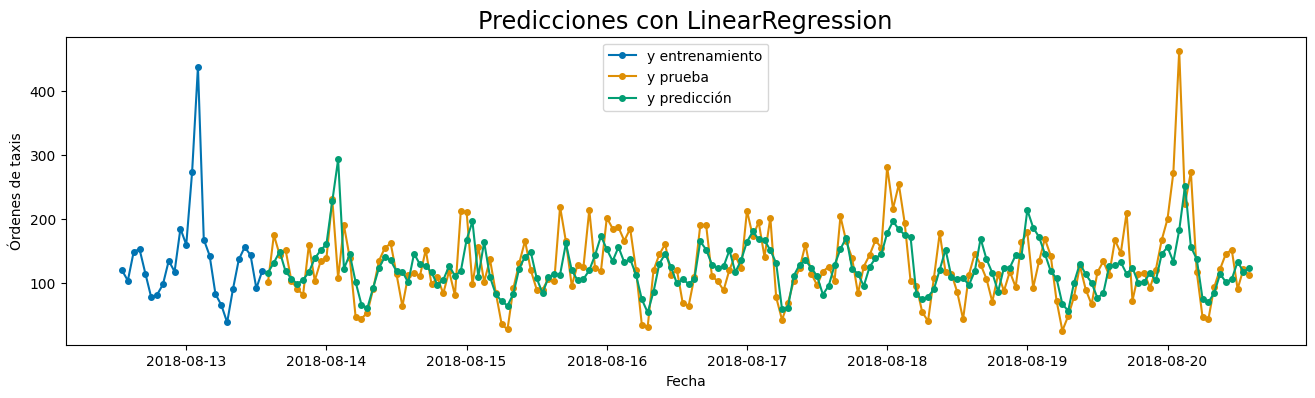

In [24]:
# Evaluación y visualización de modelo base sin optimización
model_lr = LinearRegression()
pred_lr = evaluate_model(model_lr)
summary_models

### Hallazgos

- El modelo de regresión lineal produce predicciones que siguen la tendencia general de los datos reales, pero presenta cierta dispersión respecto a los valores reales, especialmente en los picos de demanda. Tiende a subestimar los valores máximos y sobrestimar los mínimos. La dispersión de los errores es relativamente constante, sin grandes anomalías, pero no captura bien las fluctuaciones abruptas.

- La regresión lineal obtuvo un RMSE de 46.02, lo cual resulta satisfactorio, ya que se encuentra por debajo del umbral establecido de 48. Esto confirma que el modelo es adecuado como referencia o línea base para comparar el desempeño de modelos más complejos.

## Ajuste de los parámetros de modelos escogidos

En los modelos escogidos, previamente se llevó a cabo un ajuste cuidadoso de los hiperparámetros; por motivos de eficiencia se decidió acotar el rango de búsqueda en esta presentación. Al emplear GridSearchCV, se estableció como criterio mantener el número de combinaciones menor a 100, lo que permite explorar de manera suficiente las alternativas relevantes sin que el proceso resulte excesivamente lento (> 300 segundos) o demandante en recursos. Este equilibrio facilita identificar configuraciones que mejoran el desempeño del modelo, asegurando al mismo tiempo una gestión práctica y eficiente del tiempo de cómputo.

## Modelo 1: Decision Tree Regressor

Se decidió ptimizar la profundidad del árbol, el tamaño mínimo de las hojas y el número mínimo de muestras para dividir un nodo permite ajustar el modelo para que aprenda lo suficiente de los datos sin volverse demasiado complejo. Así, se buscó evitar tanto el sobreajuste como un modelo demasiado simple, logrando predicciones más precisas y robustas.

In [25]:
# Búsqueda de mejores hiperparámetros
model_dt = DecisionTreeRegressor()

params_dt = {
    'max_depth': [4, 6, 8, 10, None],           # 100 combinaciones
    'min_samples_leaf': [1, 5, 10, 15, 20],    
    'min_samples_split': [2, 5, 10, 15],       
    'random_state': [12345]
}

best_params_dt = grid_search_cv(model_dt, params_dt)

Mejores parámetros para DecisionTreeRegressor: {'max_depth': 6, 'min_samples_leaf': 10, 'min_samples_split': 2, 'random_state': 12345}


DecisionTreeRegressor con parámetros: {'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 6, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 10, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 12345, 'splitter': 'best'}


,model,rmse
0,LinearRegression,46.02
1,DecisionTreeRegressor,49.79


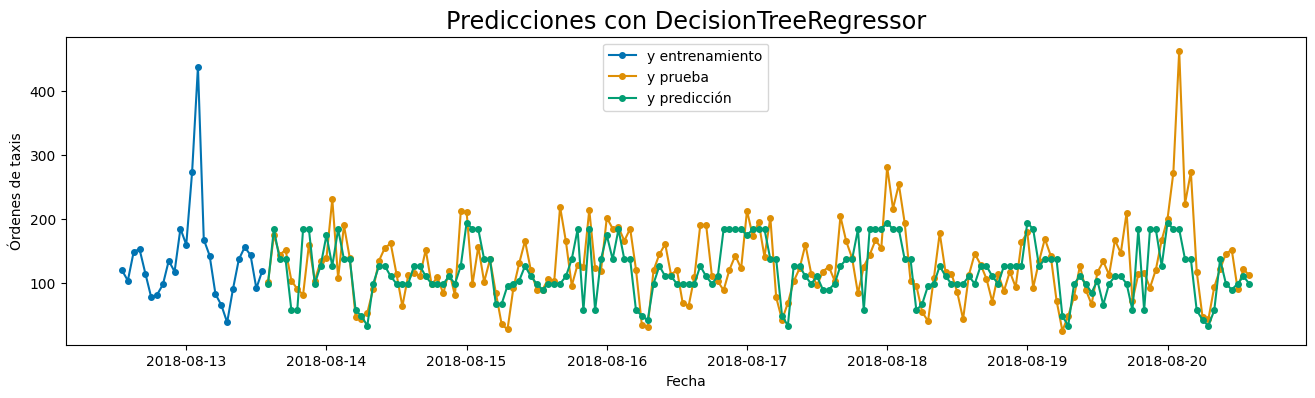

In [26]:
# Implementación de parámetros, evaluación y visualización de modelo
model_dt = DecisionTreeRegressor(**best_params_dt)
pred_dt = evaluate_model(model_dt)
summary(summary_models)

### Hallazgos:

- En términos generales, el árbol de decisión mejora la capacidad de capturar algunos picos y valles respecto al modelo lineal, adaptándose mejor a cambios abruptos. Sin embargo, puede presentar sobreajuste en algunos intervalos, ajustándose demasiado a valores atípicos del conjunto de entrenamiento. En zonas de baja variabilidad, las predicciones son más precisas, pero en zonas de alta demanda pueden aparecer errores mayores (por ejemplo, el pico del día 20).

- El modelo obtuvo un RMSE de 49.79, lo que significa que su desempeño es inferior al del modelo base de regresión lineal y no cumple con el umbral mínimo requerido de 48. Por lo tanto, este modelo se descarta para su implementación en producción.

## Modelo 2: Random Forest Regressor

En el modelo de Random Forest se optimizaron los parámetros que determinan el equilibrio entre precisión y capacidad de generalización. Al ajustar la profundidad de los árboles y el número mínimo de muestras para dividir nodos o crear hojas se buscó evitar que el modelo aprendiera ruido o patrones irrelevantes. Además, seleccionar el número adecuado de árboles permite mejorar la estabilidad de las predicciones sin hacer el modelo innecesariamente lento.

In [27]:
# Búsqueda de mejores hiperparámetros
model_rf = RandomForestRegressor()

params_rf = {'max_depth': [10, 15, 20],           
             'min_samples_leaf': [2, 4, 6],
             'min_samples_split': [2, 3, 4],
             'random_state': [12345]}

best_params_rf = grid_search_cv(model_rf, params_rf)

Mejores parámetros para RandomForestRegressor: {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 2, 'random_state': 12345}


RandomForestRegressor con parámetros: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 20, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 2, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 12345, 'verbose': 0, 'warm_start': False}


,model,rmse
0,LinearRegression,46.02
2,RandomForestRegressor,43.47


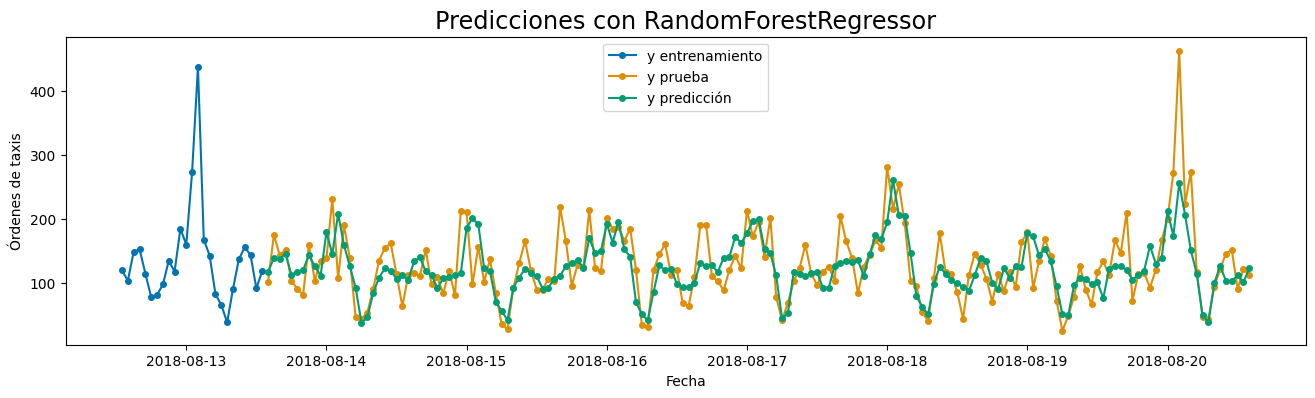

In [28]:
# Implementación de parámetros, evaluación y visualización de modelo
model_rf = RandomForestRegressor(**best_params_rf)
pred_rf = evaluate_model(model_rf)
summary(summary_models)

### Hallazgos:

- El bosque aleatorio suaviza las predicciones y reduce la varianza respecto al árbol individual, capturando mejor la estacionalidad y los patrones complejos. Muestra un menor sobreajuste que el árbol de decisión, mejorando la generalización, y predicciones más estables y cercanas a los valores reales, especialmente en los picos y valles (podemos ver que predice relativamente bien los picos de los días 14 y 15).

- El modelo obtuvo un RMSE de 43.47, superando así el desempeño de la regresión lineal utilizada como referencia (RMSE = 46.02). Estos resultados indican que el modelo es adecuado para el problema y puede considerarse una opción viable para la predicción de la demanda de taxis

## Modelo 3: Light Gradient Boosting Machine Regressor

Se decidió optimizar los parámetros de LGBMRegressor para mejorar su capacidad de generalización y precisión en la predicción de la demanda de taxis. Los parámetros ajustados, como el número de árboles (`n_estimators`) y la tasa de aprendizaje (`learning_rate`), controlaron la complejidad del modelo y el ritmo con el que aprende patrones de los datos. Ajustar estos valores permitió evitar tanto el sobreajuste como el subajuste, logrando un equilibrio entre precisión y robustez en el modelo.

In [29]:
# Búsqueda de mejores hiperparámetros
model_lgbm = LGBMRegressor()

params_lgbm = {
    'learning_rate': [0.025, 0.03, 0.05], 
    'num_leaves': [10, 20, 30],  
    'n_estimators': [500, 1000],
    'min_child_samples': [10, 20],
    'random_state': [12345],
    'verbosity': [-1]}

best_params_lgbm = grid_search_cv(model_lgbm, params_lgbm)

Mejores parámetros para LGBMRegressor: {'learning_rate': 0.03, 'min_child_samples': 10, 'n_estimators': 500, 'num_leaves': 30, 'random_state': 12345, 'verbosity': -1}


LGBMRegressor con parámetros: {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.03, 'max_depth': -1, 'min_child_samples': 10, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 500, 'n_jobs': None, 'num_leaves': 30, 'objective': None, 'random_state': 12345, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0, 'verbosity': -1}


,model,rmse
0,LinearRegression,46.02
3,LGBMRegressor,40.06


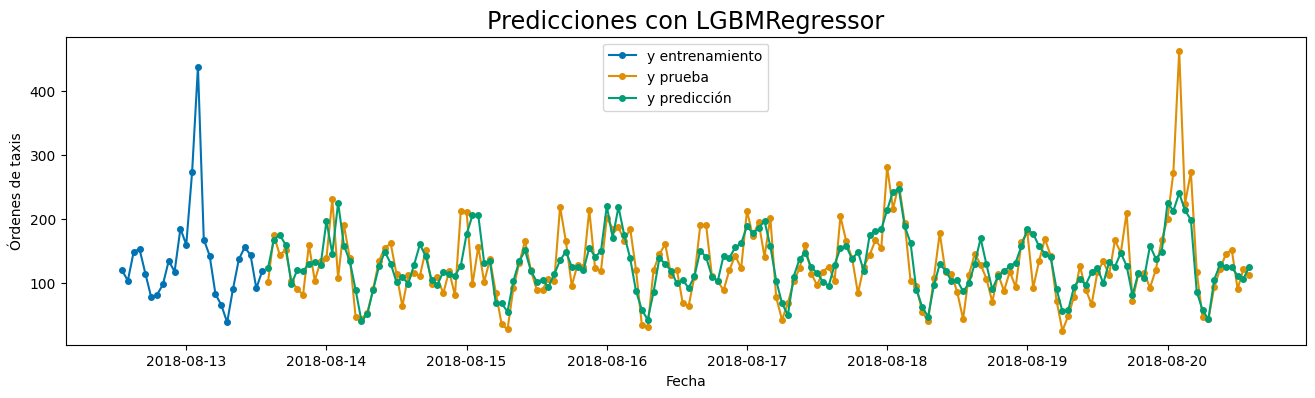

In [30]:
# Implementación de parámetros, evaluación y visualización de modelo
model_lgbm = LGBMRegressor(**best_params_lgbm)
pred_lgbm = evaluate_model(model_lgbm)
summary(summary_models)

### Hallazgos:

- El LightGBM captura muy bien la estacionalidad y los cambios bruscos, adaptándose a la naturaleza temporal de la serie. Sus predicciones muy cercanas a los valores reales, incluso en los picos de demanda. Aunque presenta ligeros errores en eventos atípicos (por ejemplo, el día 20), en general su dispersión es baja.

- Con un RMSE de 40.06, este modelo demuestra un desempeño sobresaliente y resulta altamente recomendable para tareas de predicción en este contexto.

## Modelo 4: Categorical Boosting Regressor

Se ajustaron parámetros como el número de iteraciones (`iterations`), la tasa de aprendizaje (`learning_rate`) y la profundidad del árbol (`depth`), que influyen directamente en la habilidad del modelo para capturar patrones complejos sin perder capacidad de generalización. Esta optimización ayudó a maximizar el desempeño predictivo y la estabilidad del modelo en el conjunto de prueba.

In [31]:
# Búsqueda de mejores hiperparámetros

model_cat = CatBoostRegressor()

params_cat = {
    'depth': [5, 7, 9],                  
    'learning_rate': [0.05, 0.075],       
    'iterations': [1000],          
    'random_state': [12345],
    'verbose': [False]}

best_params_cat = grid_search_cv(model_cat, params_cat)

Mejores parámetros para CatBoostRegressor: {'depth': 5, 'iterations': 1000, 'learning_rate': 0.075, 'random_state': 12345, 'verbose': False}


CatBoostRegressor con parámetros: {'iterations': 1000, 'learning_rate': 0.075, 'depth': 5, 'loss_function': 'RMSE', 'verbose': False, 'random_state': 12345}


,model,rmse
0,LinearRegression,46.02
4,CatBoostRegressor,40.52


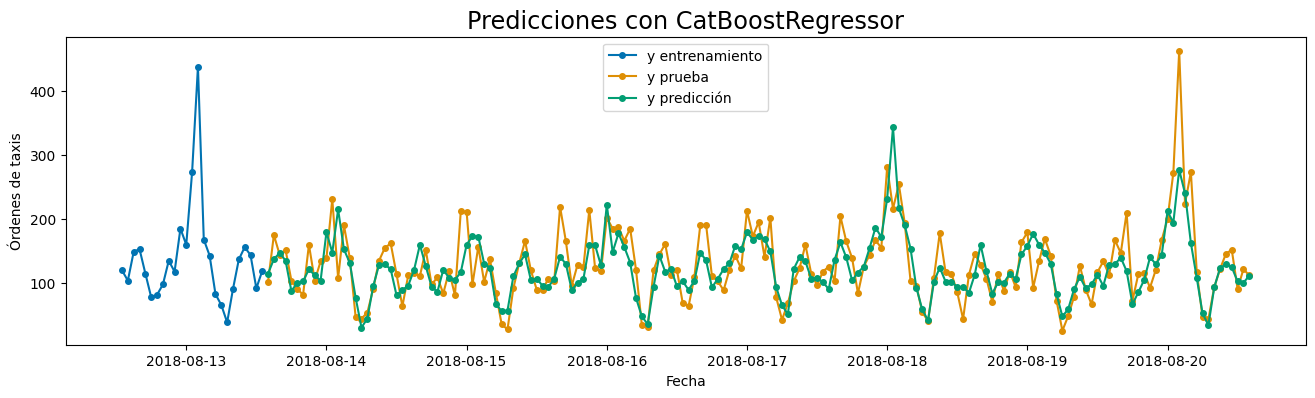

In [32]:
# Implementación de parámetros, evaluación y visualización de modelo
model_cat = CatBoostRegressor(**best_params_cat)
pred_cat = evaluate_model(model_cat)
summary(summary_models)

### Hallazgos:

- CatBoost también ofrece excelente ajuste, con gran capacidad para modelar relaciones no lineales y estacionales. Sus predicciones son muy ajustadas a los valores reales, con errores mínimos en la mayoría de los puntos. Además, se muestra muy robusto frente a valores atípicos y cambios abruptos.

- Con un RMSE de 40.52, este modelo demuestra un desempeño sobresaliente en la predicción, posicionándose también como una opción altamente eficaz para anticipar la demanda de taxis

## Modelo 5: eXtreme Gradient Boosting Regressor

Se optimizaron los parámetros de XGBRegressor para explotar su potencia en la predicción de series temporales y su control sobre el sobreajuste. Los parámetros clave ajustados incluyeron el número de árboles (`n_estimators`), la tasa de aprendizaje (`learning_rate`) y la profundidad máxima (`max_depth`). Estos parámetros permitieron controlar la complejidad del modelo y mejorar la precisión, asegurando que el modelo se adaptara a los patrones reales de la demanda sin ajustarse excesivamente al ruido de los datos.

In [33]:
# Búsqueda de mejores hiperparámetros
model_xgboost = XGBRegressor()

params_xgboost = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5],
    'learning_rate': [0.05, 0.1, 0.2],
    'subsample': [0.8, 0.9],
    'colsample_bytree': [0.7, 0.8],
    'random_state': [12345]}

best_params_xgboost = grid_search_cv(model_xgboost, params_xgboost)

Mejores parámetros para XGBRegressor: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 300, 'random_state': 12345, 'subsample': 0.9}


XGBRegressor con parámetros: {'objective': 'reg:squarederror', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 0.8, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.05, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 5, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': 300, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': 12345, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': 0.9, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}


,model,rmse
0,LinearRegression,46.02
5,XGBRegressor,41.78


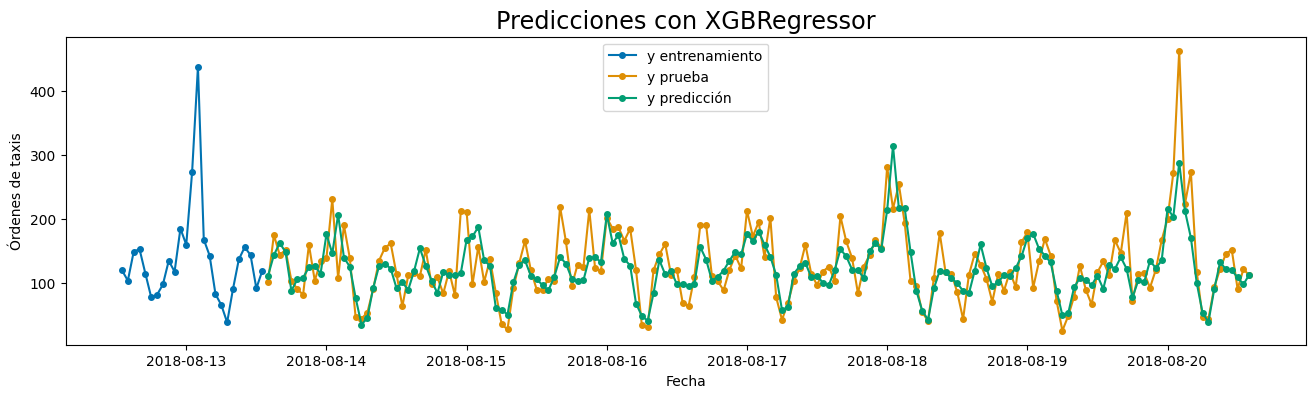

In [34]:
# Implementación de parámetros, evaluación y visualización de modelo
model_xgboost = XGBRegressor(**best_params_xgboost)
pred_xboost = evaluate_model(model_xgboost)
summary(summary_models)

### Hallazgos:

- XGBoost es otro modelo de boosting que suele destacar en series temporales. Como podemos observar, arroja predicciones muy próximas a los valores reales, con buen manejo de picos y estacionalidad. Sin embargo, tiene una tendencia a subestimar el valor de los picos.

- Con un RMSE de 41.78, este modelo supera en desempeño al modelo base de Regresión Lineal. Sin embargo, es superado por los modelos LGBMRegressor y CatBoostRegressor, que logran resultados aún más precisos.

# Diferencias observadas entre LGBMRegressor y CatBoostRegressor

In [35]:
#Tabla de resultados RMSE en todos los modelos
summary_models

,model,rmse
0,LinearRegression,46.02
1,DecisionTreeRegressor,49.79
2,RandomForestRegressor,43.47
3,LGBMRegressor,40.06
4,CatBoostRegressor,40.52
5,XGBRegressor,41.78


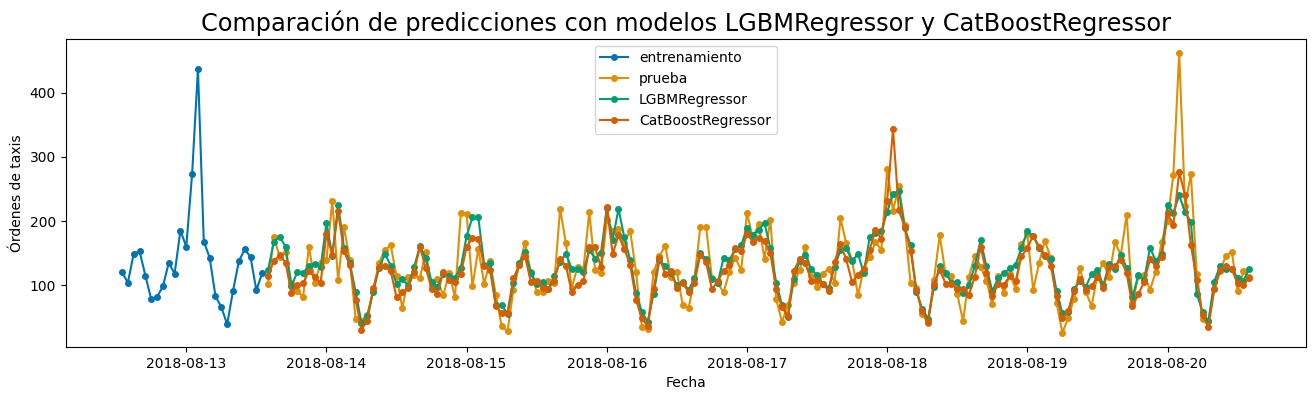

In [36]:
#Visualización del mejor y el peor modelo
plot_series(y_train[start_train:end_train], y_test[start_test:end_test], pred_lgbm[start_test:end_test], pred_cat[start_test:end_test], 
            labels=["entrenamiento", "prueba", "LGBMRegressor", "CatBoostRegressor"], 
            x_label='Fecha', 
            y_label='Órdenes de taxis',
            title='Comparación de predicciones con modelos LGBMRegressor y CatBoostRegressor');

- Ambos modelos muestran una alta capacidad para seguir la tendencia y estacionalidad de la serie temporal de pedidos de taxi, con predicciones que se superponen en gran parte del periodo analizado. La diferencia entre ambos modelos es más notoria en los momentos de mayor variabilidad (picos y valles); en periodos estables, sus predicciones prácticamente se superponen.

- El modelo **LGBMRegressor** (verde) tiende a reaccionar de manera más rápida y precisa ante los picos pronunciados en la demanda, acercándose más a los valores reales en los momentos de mayor variabilidad (días 14 al 16). Asimismo, mantiene una predicción más ajustada a los mínimos de la serie, reflejando mejor las caídas abruptas en la demanda.

- El modelo **CatBoostRegressor** (naranja oscuro), aunque también sigue los picos, en ocasiones suaviza estos valores extremos, lo que puede resultar en una ligera subestimación de la demanda máxima en horas punta. Del mismo modo, muestra una tendencia a suavizar los descensos, lo que puede llevar a sobreestimar la demanda en horas de baja actividad.

-  Ambos modelos son altamente competitivos y cumplen con el criterio de éxito (RMSE < 48), pero **LGBMRegressor parece tener una ligera ventaja en la captura de picos y valles, lo que puede ser crucial para la planificación operativa en escenarios de alta demanda.**

- CatBoostRegressor presenta predicciones ligeramente más suaves y menos ruidosas, lo que puede ser ventajoso para evitar falsas alarmas o sobreajustes ante fluctuaciones aleatorias. **LGBMRegressor, al ser más reactivo, puede reflejar mejor los cambios reales pero también es más sensible al ruido de corto plazo.**

# Conclusiones

- Se recopiló y analizó el histórico de órdenes de taxis por hora en aeropuertos, abarcando desde marzo hasta agosto de 2018, con el objetivo de predecir la demanda y optimizar la disponibilidad de conductores en horas pico. Se verificó que los datos estuvieran correctamente ordenados y se realizó un re-muestreo horario para facilitar el análisis de patrones temporales y estacionales.

- Se identificó una ligera tendencia creciente en la demanda, así como una estacionalidad diaria muy marcada, con picos recurrentes en las primeras horas de la mañana y la noche. Los residuos mostraron fluctuaciones periódicas, especialmente cada siete días, sugiriendo la influencia de factores semanales o eventos puntuales.

- Se comprobó la estacionariedad de la serie temporal mediante la prueba ADF, lo que permitió aplicar modelos de predicción adecuados. El análisis de autocorrelación (ACF) y autocorrelación parcial (PACF) reveló una fuerte dependencia temporal con los retrasos de 1, 22, 23, 24 y 25 horas, que se incluyeron como variables predictivas clave. Se crearon características adicionales, como variables de fecha y hora, retrasos seleccionados y una media móvil de 6 horas, para capturar mejor los patrones y mejorar la precisión de los modelos.

- Se dividió el conjunto de datos en entrenamiento y prueba, asegurando una validación robusta y evitando el uso de información futura en la predicción.

- Se utilizó la regresión lineal como modelo base, obteniendo un RMSE de 46.02, que sirvió como referencia para comparar el desempeño de modelos más complejos. Se entrenaron y evaluaron diversos modelos de machine learning, incluyendo DecisionTreeRegressor, RandomForestRegressor, LGBMRegressor, CatBoostRegressor y XGBRegressor, optimizando sus hiperparámetros mediante GridSearchCV y validación cruzada en series temporales.

- Se encontró que los modelos de boosting (LGBMRegressor y CatBoostRegressor) superaron al modelo base y a los modelos de árbol tradicionales, logrando los menores valores de RMSE y una mejor capacidad para capturar picos y valles en la demanda. **Si la prioridad es anticipar con precisión los picos de demanda y evitar la escasez de taxis en horas críticas, LGBMRegressor es la mejor opción. Si se busca una predicción más estable y menos sensible a fluctuaciones menores, CatBoostRegressor puede ser preferible, aunque con el riesgo de no captar completamente los extremos.**